In [115]:
import models
import numpy as np
import matplotlib.pyplot as plt

<Axes: >

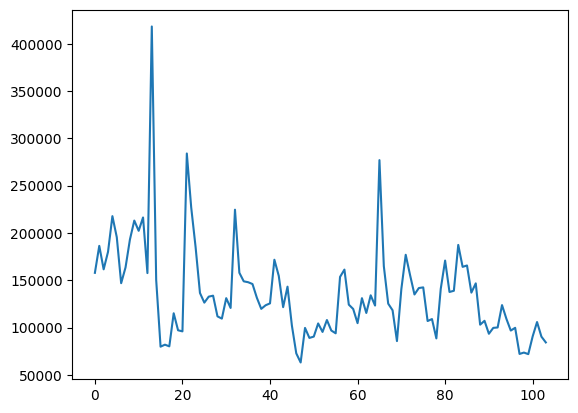

In [116]:
media = models.load_media()
revenue = media['revenue']
# plot the revenue
revenue.plot()


157707.28
136490.19067307696


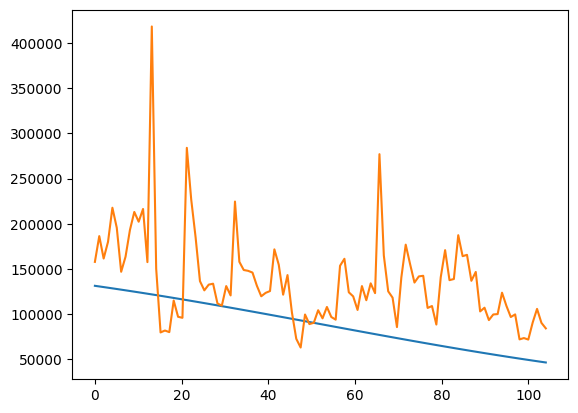

In [160]:
n = len(revenue)
t = np.linspace(0, n, n)
# value in the middle of the range
t0 = t[len(revenue) // 2]
third_quantile = revenue.quantile(0.75)
print(third_quantile)
mean = revenue.mean()
print(mean)
max = revenue.max()
capacity_coeff = 1.3
capacity = mean * capacity_coeff
growth_rate = -0.02
trend = models.logistic_curve(t, capacity, growth_rate, t0)

# plot the logistic curve
plt.plot(t, trend)
plt.plot(t, revenue)

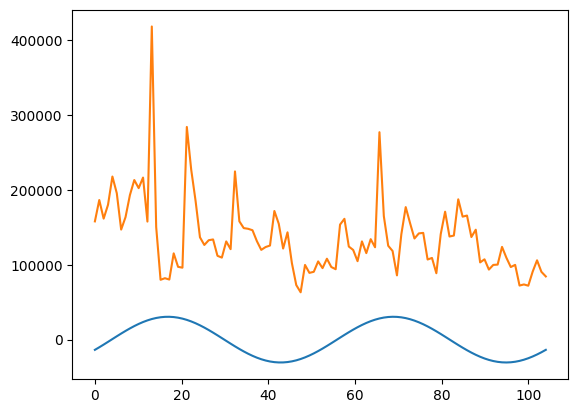

In [170]:
# model cyclic component

# summer low, winter high

base = 0
cos_ceof = -1
sin_coef = 2
period=52
year = models.cyclic_component(t, base,cos_ceof,sin_coef,period=period)
cycle_coeff = 0.1
year = year * cycle_coeff * mean
plt.plot(t, year)
plt.plot(t, revenue)
    

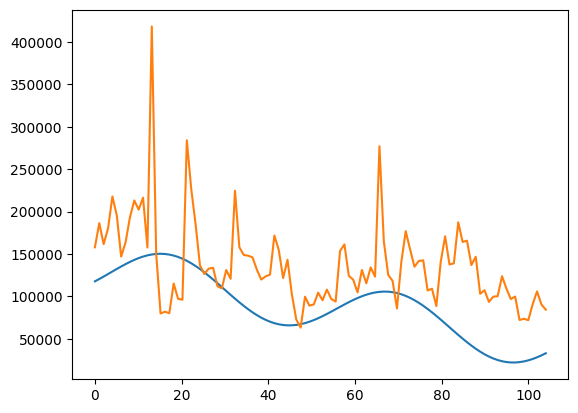

In [171]:
res = trend + year

plt.plot(t, res)
plt.plot(t, revenue)

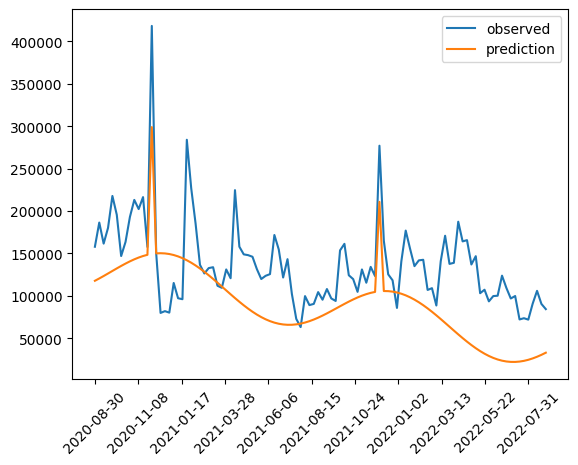

In [174]:
# black friday

def black_friday(n, offset=13, period=52):
    res = np.zeros(n)
    for i in range(n):
        if i % period == offset:
            res[i] = 1
    return res

length = len(res)
bf = black_friday(length)
bc_coef = 1
bf_contrib = bf*bc_coef*res

# print(res)
new_res = res + bf_contrib
plt.plot(t, revenue, label='observed')
plt.plot(t, new_res, label='prediction')
dates = media['start_of_week']
plt.xticks(np.arange(0, len(dates), 10), dates.dt.date[::10], rotation=45)
plt.legend()

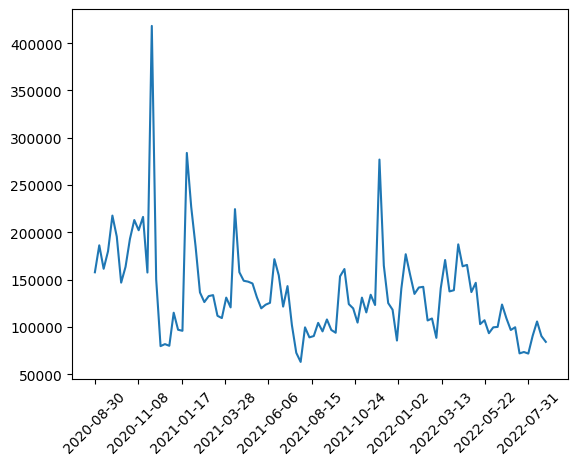

In [6]:
plt.plot(t, revenue)
dates = media['start_of_week']
plt.xticks(np.arange(0, len(dates), 10), dates.dt.date[::10], rotation=45)
plt.show()

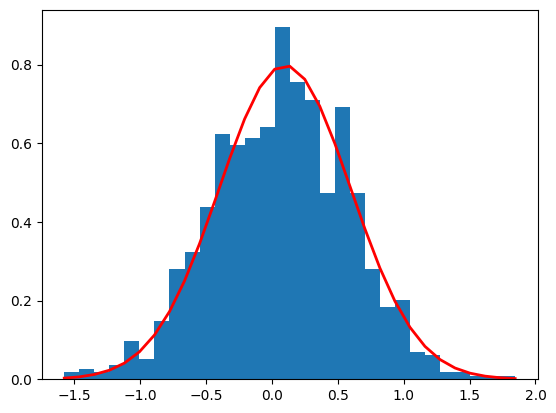

In [7]:
# plot normal distribution (numpy.random.normal)
mu=0.1
sigma=0.5

x = np.random.normal(mu, sigma, 1000)

count, bins, ignored = plt.hist(x, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')

In [8]:
# model delay
media = models.load_media()
media = models.delay(media, default_lag=0, retention_rate=0.5, retention_length=4)
models.plot_media(media)

TypeError: delay() got an unexpected keyword argument 'default_lag'

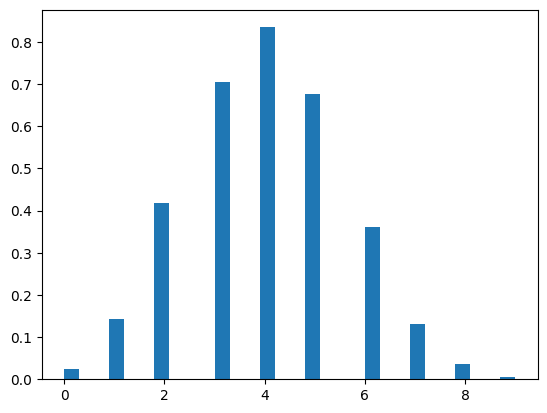

In [ ]:
# show binomial distribution
n = 10
k = 4
p = k/n
s = np.random.binomial(n, p, 5000)
# convert to elements between 0 and 1


count, bins, ignored = plt.hist(s, 30, density=True)
plt.show()

Adstock Weights: [0.13421773 0.4096     0.8        1.         0.8       ]
Adstocked Spend Data: [ 25.44676789  82.70199563 165.40399126 261.13473205 361.13473205
 461.13473205 484.79442839 463.92228093 404.87998164 300.38975491
 202.78754888]


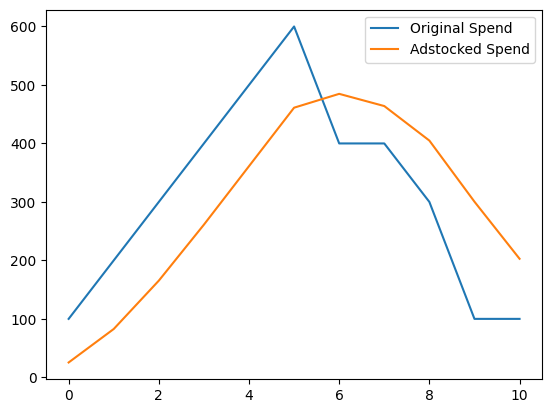

In [20]:
import numpy as np

# Example spend data (replace with your actual data)
spend_data = np.array([100, 200, 300, 400, 500, 600, 400, 400, 300, 100, 100])

# Parameters for delayed_adstock
alpha = 0.8  # decay parameter
theta = 3  # lag parameter
L = 5        # length of the weight series

# Generate adstock weights
weights = models.delayed_adstock(alpha, theta, L)

print("Adstock Weights:", weights)

# Function to apply adstock effect to spend data
def apply_delayed_adstock(spend_data, weights):
    # Ensure weights sum to 1
    weights /= weights.sum()
    
    # Calculate the weighted sum using convolution
    adstocked_spend = np.convolve(spend_data, weights[::-1], mode='full')[:len(spend_data)]
    
    return adstocked_spend

# Apply the adstock function to the spend data
adstocked_spend_data = apply_delayed_adstock(spend_data, weights)

print("Adstocked Spend Data:", adstocked_spend_data)

# plot the adstocked spend data
plt.plot(spend_data, label='Original Spend')
plt.plot(adstocked_spend_data, label='Adstocked Spend')
plt.legend()
plt.show()

In [70]:
def _delayed_adstock(alpha, theta, L):
    return alpha**((np.ones(L).cumsum()-1)-theta)**2

In [110]:
import pytensor.tensor as pt
import pytensor.tensor.conv as ptconv

data = np.array([1.0, 2.0, 3.0, 4.0, 5., 6., 7., 8., 9., 10.])
alpha = 0.8
theta = 3
L = 5
weights = _delayed_adstock(alpha, theta, L)

print(weights)
weights /= weights.sum()
adstocked_spend = np.convolve(data, weights[::-1], mode='full')[:len(data)]
print(adstocked_spend)
# Create a tensor from the data
data = pt.as_tensor_variable(data)
weights = pt.as_tensor_variable(weights)



# res = np.convolve(data_,weights[::-1], mode='full')[:tensor.shape[0].eval()]
# print(res)
weights = weights[::-1]
n_data = data.shape[0]
n_weights = weights.shape[0]
data = data.reshape((1, 1, 1, n_data) ) # Reshape for conv2d
weights = weights.reshape((1, 1, 1, n_weights))  # Reshape for conv2d
res = ptconv.conv2d(data, weights, border_mode='full')
res = res.reshape((n_data + (n_weights - 1),))
res = res[:n_data]
res.eval()


[0.13421773 0.4096     0.8        1.         0.8       ]
[0.25446768 0.82701996 1.65403991 2.61134732 3.61134732 4.61134732
 5.61134732 6.61134732 7.61134732 8.61134732]


array([0.25446768, 0.82701996, 1.65403991, 2.61134732, 3.61134732,
       4.61134732, 5.61134732, 6.61134732, 7.61134732, 8.61134732])

In [111]:
res = alpha ** ((pt.arange(L)) - theta) ** 2
res.eval()

array([0.13421773, 0.4096    , 0.8       , 1.        , 0.8       ])